# 👾 PixelCNN using Tensorflow distributions

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset using Tensorflow distributions

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display

2023-07-24 18:46:05.906121: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 18:46:05.933226: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 18:46:05.933956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 18:46:06.465657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
N_COMPONENTS = 5
EPOCHS = 10
BATCH_SIZE = 128

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [4]:
# Preprocess the data


def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


input_data = preprocess(x_train)

2023-07-24 18:46:07.828422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 18:46:07.828846: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-07-24 18:46:07.843227: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


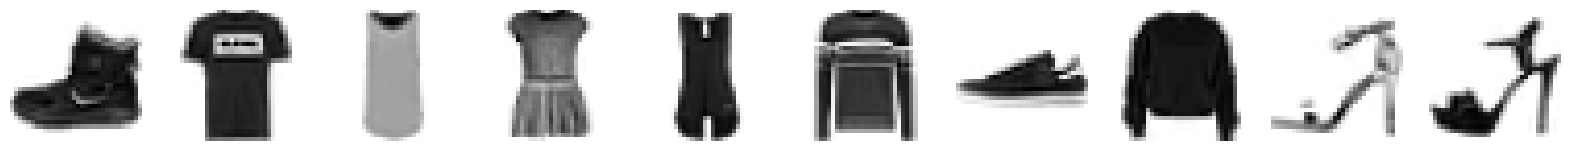

In [5]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN <a name="build"></a>

In this notebook, we are going to use the premade PixelCNN from TensorFlow and use the TensorFlow Probability $\texttt{distributions}$ function to create a *mixture distribution*, wherein we are going to sample from a categorical distribution to choose our logistic distribution and then sample from our logistic distribution. A mixture distribution might look like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/LogisticPDF.png' alt='LogisticPDF' width='500'>
</div>

This has a pdf of:

$$ f(x; \mu, s) = \frac{1}{4}sech^2 \left( \frac{x-\mu}{2s} \right) $$ 

So, we will leave our image as a grayscale where each pixel value is in $[0,1]$, and then calculate the *Log Likelihood*, or the log of the likelihood, as our loss function. This means:

$$\mathcal{L} = l(\theta, \mathbf{x})=\ln (L(\theta, \mathbf{x})) = \ln (f_{\theta}(\mathbf{x})
)$$

In [7]:
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2, # int, the number of hightest-level blocks (separated by expansions/contractions of dimensions in Figure 2 of [1].)
    num_filters=32, # int, the number of convolutional filters.
    num_logistic_mix=N_COMPONENTS, # int, number of components in the logistic mixture distribution.
    dropout_p=0.3,
)

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob)
pixelcnn.add_loss(-tf.reduce_mean(log_prob))

2023-07-24 18:55:29.060083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,32,32,64]
	 [[{{node Placeholder}}]]
2023-07-24 18:55:29.361621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,16,16,64]
	 [[{{node Placeholder}}]]
2023-07-24 18:55:29.495529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,16,16,64

## 3. Train the PixelCNN <a name="train"></a>

In [8]:
# Compile and train the model
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [11]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2:
            generated_images = self.generate()
            display(
                generated_images,
                n=self.num_img,
                save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/03_pixelcnn_md/output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_img=2)

Layer _PixelCNNNetwork was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10


2023-07-24 21:12:18.234587: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


469/469 [==============================] - 692s 1s/step - loss: 1971.6146
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 1921.8024
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/03_pixelcnn_md/output/generated_img_001.png


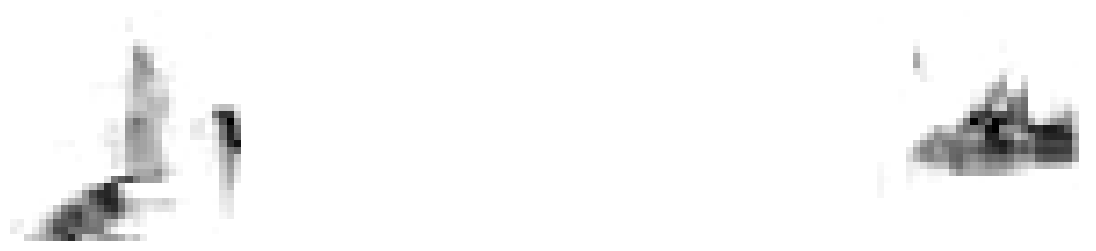

469/469 [==============================] - 741s 2s/step - loss: 1921.8024
Epoch 3/10
469/469 [==============================] - 689s 1s/step - loss: 1881.2306
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 1852.6085
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/03_pixelcnn_md/output/generated_img_003.png


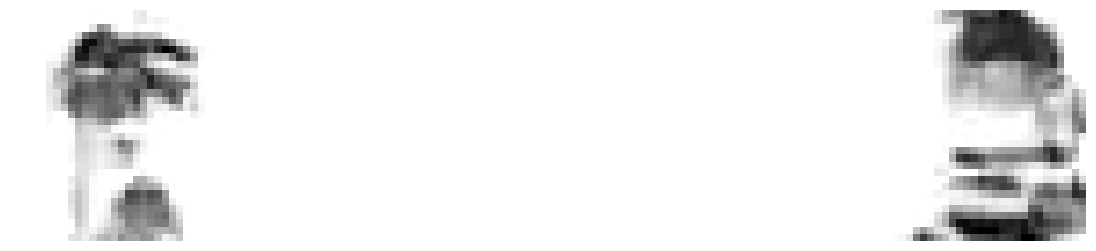

469/469 [==============================] - 742s 2s/step - loss: 1852.6085
Epoch 5/10
469/469 [==============================] - 691s 1s/step - loss: 1827.7561
Epoch 6/10
469/469 [==============================] - ETA: 0s - loss: 1810.9113
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/03_pixelcnn_md/output/generated_img_005.png


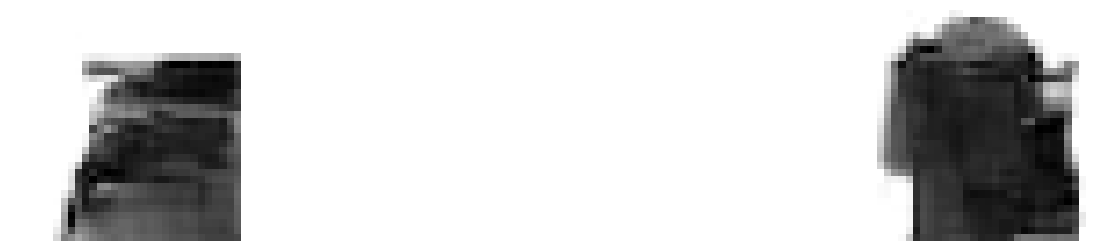

469/469 [==============================] - 742s 2s/step - loss: 1810.9113
Epoch 7/10
469/469 [==============================] - 690s 1s/step - loss: 1796.3584
Epoch 8/10
469/469 [==============================] - ETA: 0s - loss: 1779.1859
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/03_pixelcnn_md/output/generated_img_007.png


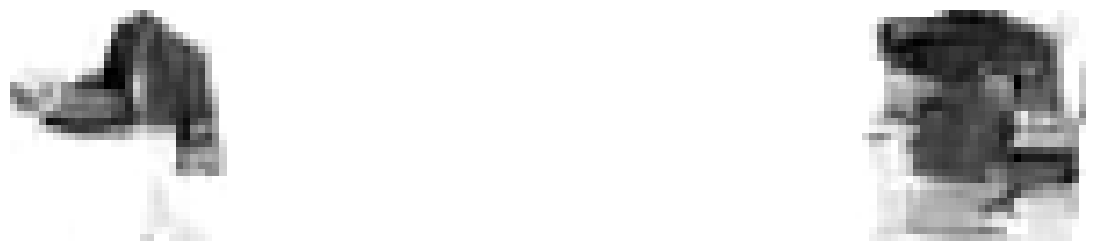

469/469 [==============================] - 741s 2s/step - loss: 1779.1859
Epoch 9/10
469/469 [==============================] - 689s 1s/step - loss: 1769.2601
Epoch 10/10
469/469 [==============================] - ETA: 0s - loss: 1759.4991
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/03_pixelcnn_md/output/generated_img_009.png


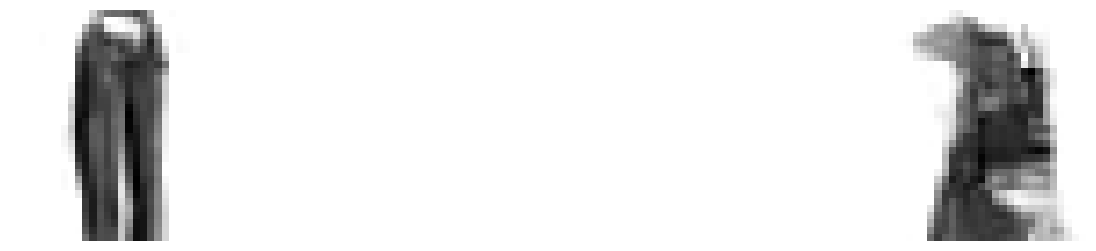

469/469 [==============================] - 742s 2s/step - loss: 1759.4991


In [12]:
pixelcnn.fit(
    input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [13]:
generated_images = img_generator_callback.generate()

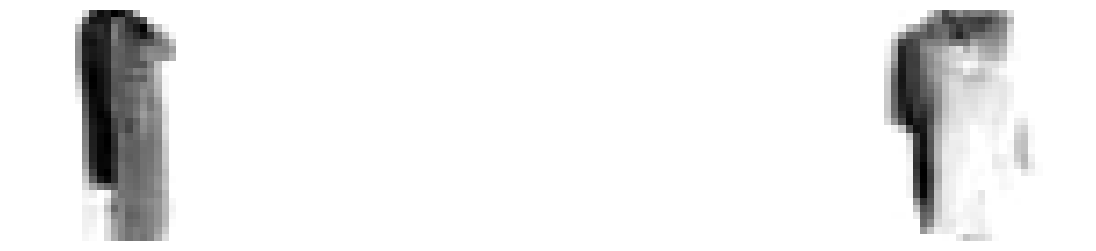

In [14]:
display(generated_images, n=img_generator_callback.num_img)